<a href="https://colab.research.google.com/github/georgeputhean/Hobby-Projects/blob/main/Fashion_MNIST_Data_Kaggle_Competiton_Accuracy_99_12_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# import Kaggle API
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 69 bytes


In [ ]:
# download data for competitions
!kaggle competitions download -c digit-recognizer

 33% 5.00M/15.3M [00:00<00:00, 48.5MB/s]
100% 15.3M/15.3M [00:00<00:00, 105MB/s] 


In [ ]:
# unzipping the data files
!unzip /content/digit-recognizer.zip

Archive:  /content/digit-recognizer.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


In [ ]:
# import the necessary libraries
import math
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
import numpy as np
np.random.seed(2)

In [ ]:
# loading training and test data
test = pd.read_csv("/content/test.csv")
train = pd.read_csv("/content/train.csv")

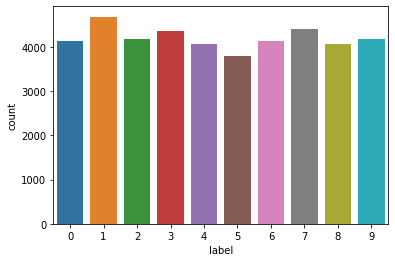

In [ ]:
# count plot which shows the number of each label in training data
sns.countplot(x=train['label'],)
plt.show()

In [ ]:
# setting constant values
test_size_ratio=0.1
random_seed=np.random.seed(2)

In [ ]:
# outout data after the label is removed
outputdata = train["label"]

# Drop 'label' column
inputdata = train.drop(labels = ["label"],axis = 1)

In [ ]:
# split the data into training and validation
in_train, in_valid, out_train, out_valid = train_test_split(inputdata, outputdata, test_size = test_size_ratio, random_state=random_seed)

In [ ]:
in_train.shape, in_valid.shape, np.unique(out_train)

((37800, 784), (4200, 784), array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]))

In [ ]:
# reshape the train data
in_train = in_train.values.reshape(-1,28,28)

In [ ]:
in_train.shape

(37800, 28, 28)

In [ ]:
# define ten categories from 0 to 9
class_names = {index:cn for index, cn in enumerate([0,1,2,3,4,5,6,7,8,9])}
class_names

{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9}

How many rows of training images would you like to review :1


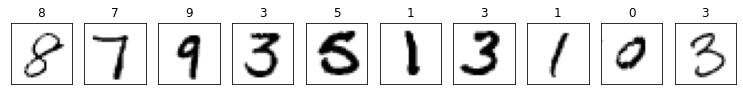

In [ ]:
def plot(images, labels, predictions=None):
    # create a grid with 10 columns
    n_cols = min(10, len(images))
    n_rows = math.ceil(len(images) / n_cols)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols + 3, n_rows + 2))
    if predictions is None:
        predictions = [None] * len(labels)
    for index, (x, y_true, y_pred) in enumerate(zip(images, labels, predictions)):
        ax = axes.flat[index]
        ax.imshow(x, cmap=plt.cm.binary)
        ax.set_title(class_names[y_true])
        if y_pred is not None:
            ax.set_xlabel(class_names[y_pred])
        ax.set_xticks([])
        ax.set_yticks([])
# input the numbers to preview
n=int(input("How many rows of training images would you like to review :"))
# plot first n row of images
plot(in_train[:10*n], out_train[:10*n])

In [ ]:
# normalisation of the data
in_train = in_train / 255.0
in_valid = in_valid / 255.0

In [ ]:
epochs=50
early_stopping = keras.callbacks.EarlyStopping( patience = 5,min_delta = 1e-3,restore_best_weights=True)

def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)
LR = LearningRateScheduler(scheduler)
STEPS = len(in_train) // 64

In [ ]:
# set call backs for the fit functions
from keras.callbacks import LearningRateScheduler
callback = LearningRateScheduler(lambda x: 1e-3 * 0.9 ** x)

In [ ]:
# setup model and layers

model = keras.Sequential(layers=[
    keras.layers.Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', activation ='relu', input_shape = (28,28,1)),
    keras.layers.Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu', input_shape = (28,28,1)),
    keras.layers.MaxPool2D(strides=(2,2)),


    keras.layers.Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu', input_shape = (28,28,1)), # hidden size filters increase
    keras.layers.Conv2D(filters = 256, kernel_size = (3,3),padding = 'Same', activation ='relu', input_shape = (28,28,1)),
    keras.layers.MaxPool2D(strides=(2,2)),


    keras.layers.Flatten(),
    keras.layers.Dense(512, activation = "relu"),
    keras.layers.Dense(1024, activation = "relu"),
    keras.layers.Dense(10, activation="softmax")
    ])
adam = tf.keras.optimizers.Adam(learning_rate = 1e-4)
model.compile(optimizer=adam, loss="sparse_categorical_crossentropy", metrics=["accuracy"])


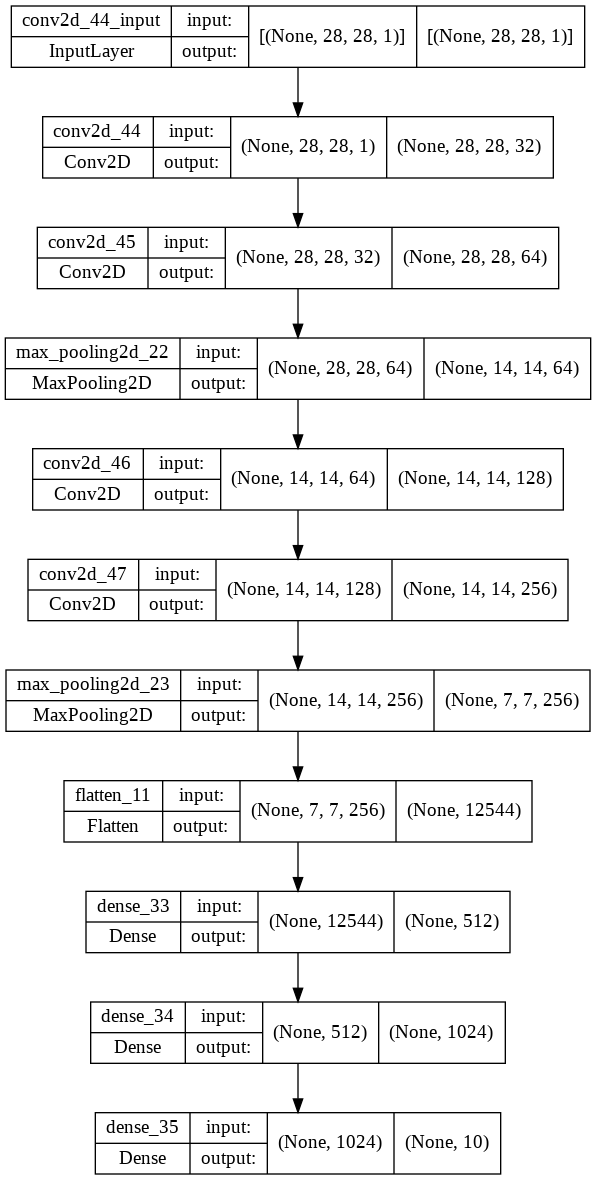

In [ ]:
# plot the model setup
keras.utils.plot_model(model, to_file='test_keras_plot_model.png', show_shapes=True)

In [ ]:
# history function to store the epoch results
history = model.fit(in_train, out_train, batch_size=64, epochs=50, validation_split=0.15, callbacks=[early_stopping, callback],steps_per_epoch=STEPS)

Epoch 1/50
590/590 [==============================] - 6s 9ms/step - loss: 0.1465 - accuracy: 0.9529 - val_loss: 0.0826 - val_accuracy: 0.9757 - lr: 0.0010
Epoch 2/50
590/590 [==============================] - 5s 9ms/step - loss: 0.0396 - accuracy: 0.9873 - val_loss: 0.0386 - val_accuracy: 0.9894 - lr: 9.0000e-04
Epoch 3/50
590/590 [==============================] - 5s 9ms/step - loss: 0.0209 - accuracy: 0.9934 - val_loss: 0.0393 - val_accuracy: 0.9891 - lr: 8.1000e-04
Epoch 4/50
590/590 [==============================] - 5s 9ms/step - loss: 0.0156 - accuracy: 0.9954 - val_loss: 0.0397 - val_accuracy: 0.9884 - lr: 7.2900e-04
Epoch 5/50
590/590 [==============================] - 5s 9ms/step - loss: 0.0104 - accuracy: 0.9966 - val_loss: 0.0376 - val_accuracy: 0.9910 - lr: 6.5610e-04
Epoch 6/50
590/590 [==============================] - 5s 9ms/step - loss: 0.0087 - accuracy: 0.9971 - val_loss: 0.0481 - val_accuracy: 0.9889 - lr: 5.9049e-04
Epoch 7/50
590/590 [==============================

In [ ]:
# save the model
model.save('model_final.pt')

INFO:tensorflow:Assets written to: model_final.pt/assets


In [ ]:
# shape the validation data
in_valid = in_valid.values.reshape(-1,28,28)

AttributeError: ignored

In [ ]:
final_loss,final_accuracy = model.evaluate(in_valid,out_valid)

132/132 [==============================] - 0s 4ms/step - loss: 0.0319 - accuracy: 0.9912


In [ ]:
# Accuracy vs Epoch
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()


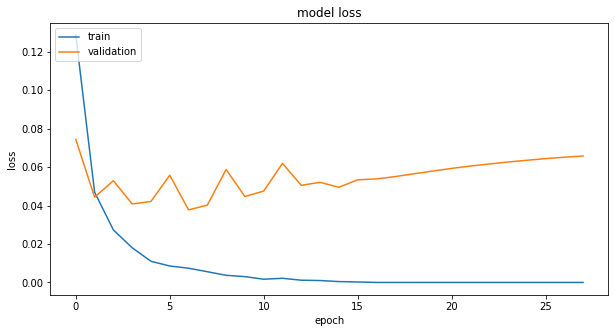

In [ ]:
# Loss vs Epoch
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
# probabilties and Prediction for Validation
preds_valid = model.predict(in_valid).argsort()[:,-1]
print(preds_valid)
probs_valid = model.predict(in_valid)
print(probs_valid.argmax(axis=1))

[6 9 5 ... 2 2 6]
[6 9 5 ... 2 2 6]


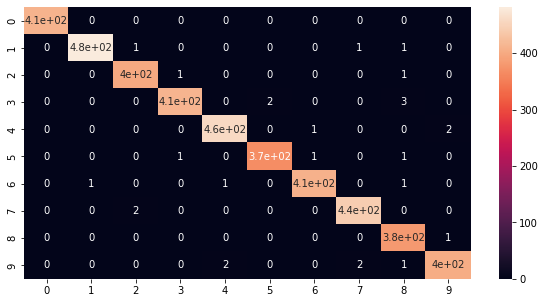

In [ ]:
# creating confusion matrix and then heatmap
conf_matrix = tf.math.confusion_matrix(labels=out_valid, predictions=preds_valid)
plt.rcParams["figure.figsize"] = (10,5)
sns.heatmap(conf_matrix,annot=True)
plt.show()

How many rows of testing images would you like to review? 1


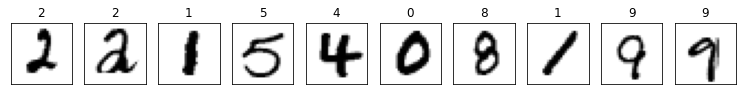

In [ ]:
# plot 20 random data
import numpy as np
i=int(input("How many rows of testing images would you like to review? "))
rand_idxs = np.random.permutation(len(in_valid))[:10*i]
plot(in_valid[rand_idxs],preds_valid[rand_idxs])

In [ ]:
# this code makes a browser application which compare the image to  the probability towards the label based on the prediction
from ipywidgets.widgets.widget_layout import Layout
from ipywidgets import interact, widgets, Layout
img_idx_slider = widgets.IntSlider(value=0, min=0, max=len(in_valid) - 1, description="Image index", layout=Layout(width='75%')) #increased the length og image index
@interact(index=img_idx_slider)
def visualize_prediction(index=0):
    fix, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    ax1.imshow(in_valid[index], cmap=plt.cm.binary)
    ax1.set_xlabel("predict: %s" % class_names[preds_valid[index]])
    ax2.bar(x=[class_names[index] for index in range(10)], height=probs_valid[index]*100)
    ax2.set_xlabel("Label")#adding x label
    ax2.set_ylabel("Probability") #added y label
    ax2.set_xticks(range(10)) #set x ticks
    ax2.set_title("Probability vs Digits")


interactive(children=(IntSlider(value=0, description='Image index', layout=Layout(width='75%'), max=4199), Out…

In [ ]:
# reshape test data
test = test.values.reshape(-1,28,28)

AttributeError: ignored

In [ ]:
# predict and get prob of the test set
probs = model.predict(test)
print(probs.argmax(axis=1))

preds = model.predict(test).argsort()[:,-1]
print(preds)

[2 0 9 ... 3 9 2]
[2 0 9 ... 3 9 2]


In [ ]:
# create a submission file.
results = pd.Series(preds,name="Label")
submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),results],axis = 1)
submission.to_csv("/content/mnist_submission.csv",index=False)


In [ ]:
!kaggle competitions submit digit-recognizer -f /content/mnist_submission.csv -m "The Submit3"

100% 208k/208k [00:00<00:00, 1.06MB/s]
Successfully submitted to Digit Recognizer